### PROBLEM 1

(88973,)
[    0.            21.53320312    43.06640625    64.59960938
    86.1328125    107.66601562   129.19921875   150.73242188
   172.265625     193.79882812   215.33203125   236.86523438
   258.3984375    279.93164062   301.46484375   322.99804688
   344.53125      366.06445312   387.59765625   409.13085938
   430.6640625    452.19726562   473.73046875   495.26367188
   516.796875     538.33007812   559.86328125   581.39648438
   602.9296875    624.46289062   645.99609375   667.52929688
   689.0625       710.59570312   732.12890625   753.66210938
   775.1953125    796.72851562   818.26171875   839.79492188
   861.328125     882.86132812   904.39453125   925.92773438
   947.4609375    968.99414062   990.52734375  1012.06054688
  1033.59375     1055.12695312  1076.66015625  1098.19335938
  1119.7265625   1141.25976562  1162.79296875  1184.32617188
  1205.859375    1227.39257812  1248.92578125  1270.45898438
  1291.9921875   1313.52539062  1335.05859375  1356.59179688
  1378.125     

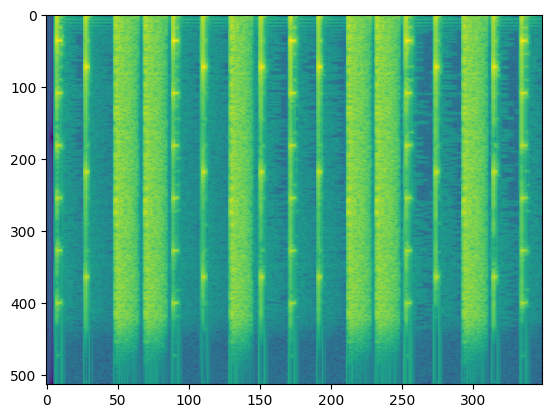

In [3]:
import scipy.signal as signal
import numpy as np
from scipy.io import wavfile
from  scipy.sparse.linalg import eigs
import matplotlib.pyplot as plt

file_path = './vl1.wav'
sampling_rate, audio_data = wavfile.read(file_path)
audio_data = audio_data.astype('float')

print(audio_data.shape)
freqs, times, spec = signal.stft(audio_data, fs=sampling_rate, window='hamming', nperseg=1024, noverlap=768)
print(freqs)
spec = np.abs(spec)
print(spec.shape)
toPlot = 10*np.log10(spec)
plt.imshow(toPlot, aspect='auto')
print(np.argmax(spec[:,50]))

In [2]:
mean = np.mean(spec,axis = 1).reshape(spec.shape[0],1)
stdev = np.std(np.ndarray.flatten(spec))

data = (spec - mean)

## PCA

In [3]:
#Part 1 
def pca(data): #takes input data as columns and expects it to be 0 mean (add mean back later if intended)
        covariance_matrix = np.dot(data,data.T)/(data.shape[1])
        eigvals, eigvecs = np.linalg.eigh(covariance_matrix)
        eigvals = eigvals[::-1]
        eigvecs = eigvecs[:,::-1]

        return (eigvecs,eigvals)

eigvecs, eigvals = pca(data)
PCAmat = eigvecs.T

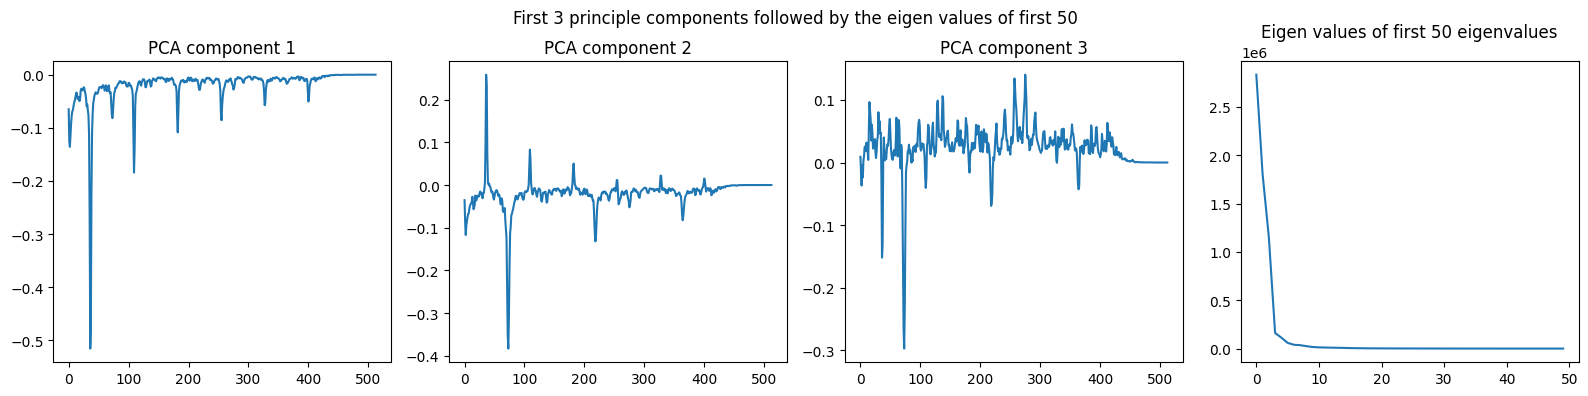

In [4]:
import numpy as np
import matplotlib.pyplot as plt

v1 =  eigvecs[:,0]  
v2 =  eigvecs[:,1]
v3 = eigvecs[:,2]  

f, a = plt.subplots(1, 4, figsize=(16, 4))
a[0].plot(v1)
a[0].set_title(f'PCA component 1')

a[1].plot(v2)
a[1].set_title(f'PCA component 2')

a[2].plot(v3)
a[2].set_title(f'PCA component 3')

a[3].plot(eigvals[:50])
a[3].set_title(f'Eigen values of first 50 eigenvalues')
plt.tight_layout()
plt.subplots_adjust(top=0.85, hspace=0.5)

plt.suptitle('First 3 principle components followed by the eigen values of first 50')
plt.show()

Text(0.5, 1.0, 'argmax of spectrogram columns along their projection to the principal components\n          \n        (shows which component each column of spec coorelates most with)')

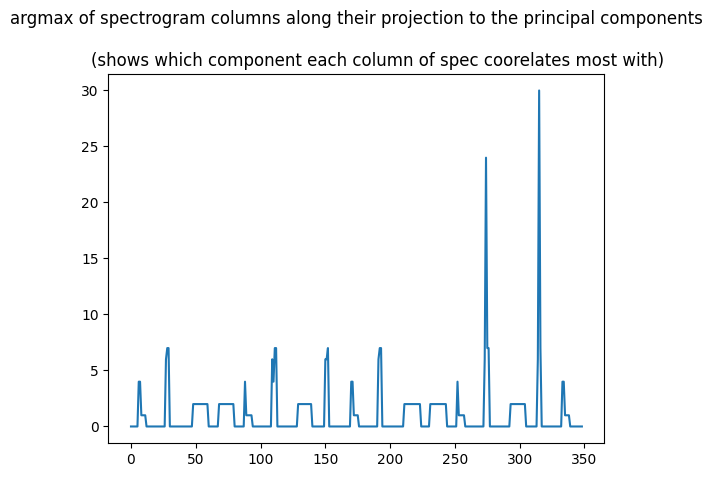

In [5]:
temp = PCAmat @ (spec-mean)
plt.plot(np.argmax(temp,axis=0))
plt.title('''argmax of spectrogram columns along their projection to the principal components
          
        (shows which component each column of spec coorelates most with)''')

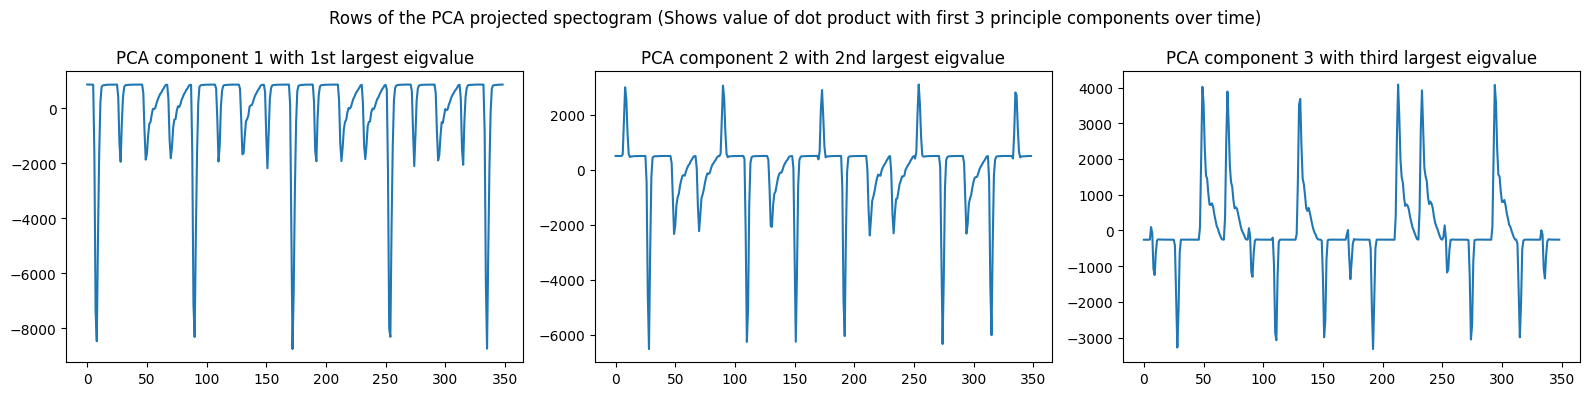

In [6]:

 #component i=3 has the the longer snare 
v1 = temp[0]
v2 =  temp[1] 
v3 = temp[2]
# v4 = temp[3]
f, a = plt.subplots(1, 3, figsize=(16, 4))

a[0].plot(v1)
a[0].set_title(f'PCA component 1 with 1st largest eigvalue')

a[1].plot(v2)
a[1].set_title(f'PCA component 2 with 2nd largest eigvalue')

a[2].plot(v3)
a[2].set_title(f'PCA component 3 with third largest eigvalue')

# a[3].plot(v4)
# a[3].set_title(f'PCA component 4 with fourth largest eigvalue')

plt.suptitle('Rows of the PCA projected spectogram (Shows value of dot product with first 3 principle components over time)')
plt.subplots_adjust(top=0.85, hspace=0.5)

plt.tight_layout()
plt.show()


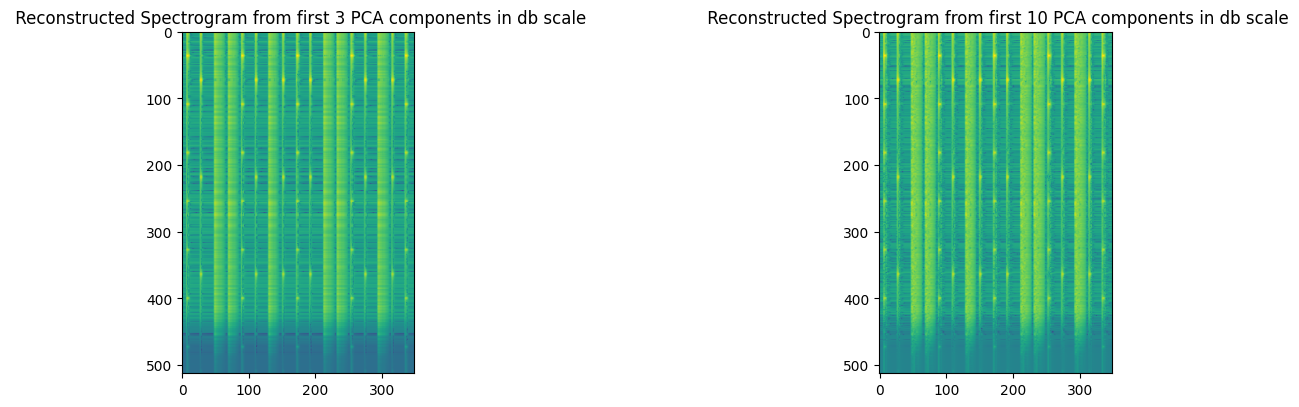

In [7]:
reconstructedPCA3 = (eigvecs[:,:3] @ temp[:3]) + mean
reconstructedPCA4 = (eigvecs[:,0:10] @ temp[0:10]) + mean

plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.imshow(10*np.log(np.abs(reconstructedPCA3)))
# plt.imshow(10*np.log(np.abs(np.amin(reconstructedPCA3)) + 1e-7 + reconstructedPCA3))
plt.title(' Reconstructed Spectrogram from first 3 PCA components in db scale')
plt.subplot(1,2,2)
plt.imshow(10*np.log(np.abs(reconstructedPCA4 )))

plt.title(' Reconstructed Spectrogram from first 10 PCA components in db scale')
plt.subplots_adjust(wspace=2) 
plt.show()
print()

### ANALYSIS  
    
  Based on the argmax plot above it seems that there is clearly a pattern in that the columns of our spectrogram correlate most with one of the first 9 or so Principal components at most times 
  
  It seems like the highest eigenvalue principal component is mostly related to the first sound in our audio value, the second mostly relates to the second sound, and the third mostly relates to the third sound.   This can be clearly seen in the plots where i show the projection onto each of the first 3 PCA components for each time value. It is also clear that each of these 3 components  are picking up information about the other 2 sounds as well.



  ## ICA 

In [8]:

def ica(data,PCAcomponents = -1, maxIter=500, alpha = 1e-6): #takes input data as columns
    
    if(PCAcomponents < 0):
        PCAcomponents = eigvecs.shape[1]
        
    W = np.zeros((PCAcomponents,PCAcomponents))
    Winitialval = 1/np.std(np.ndarray.flatten(data)) #changing this value matters a lot
    for i in range(PCAcomponents):
        W[i][i] = Winitialval 
    eigvecs, eigvals = pca(data)
    data =  eigvecs.T[:PCAcomponents] @ data

    N = data.shape[1]
    for i in range(maxIter):
        y =  W @ data
        grad = (N*np.identity(data.shape[0]) - (2*np.tanh(y) @ y.T)) @ W
        W = W + alpha * grad
        W = W
    return W  @ eigvecs.T[:PCAcomponents]
            
            

In [9]:
numPCA = 3
icaProjectMat = ica(data,numPCA, maxIter=1000, alpha = 1e-4) 
inverseIcaProjectMat = np.linalg.pinv(icaProjectMat)
toShow = inverseIcaProjectMat

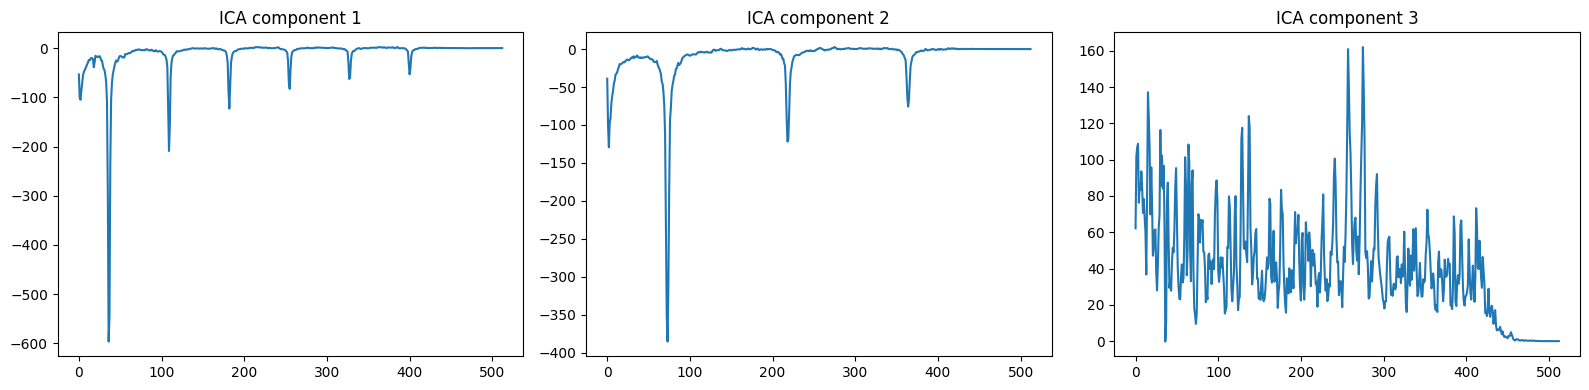

In [10]:
v1 =  toShow[:,0]  
v2 =  toShow[:,1]
v3 = toShow[:,2]  
f, a = plt.subplots(1, 3, figsize=(16, 4))
a[0].plot(v1)
a[0].set_title(f'ICA component 1')

a[1].plot(v2)
a[1].set_title(f'ICA component 2')

a[2].plot(v3)
a[2].set_title(f'ICA component 3')

# a[3].plot(v4)
# a[3].set_title(f'Eigen values of first 50 eigenvalues')
plt.tight_layout()
plt.show()

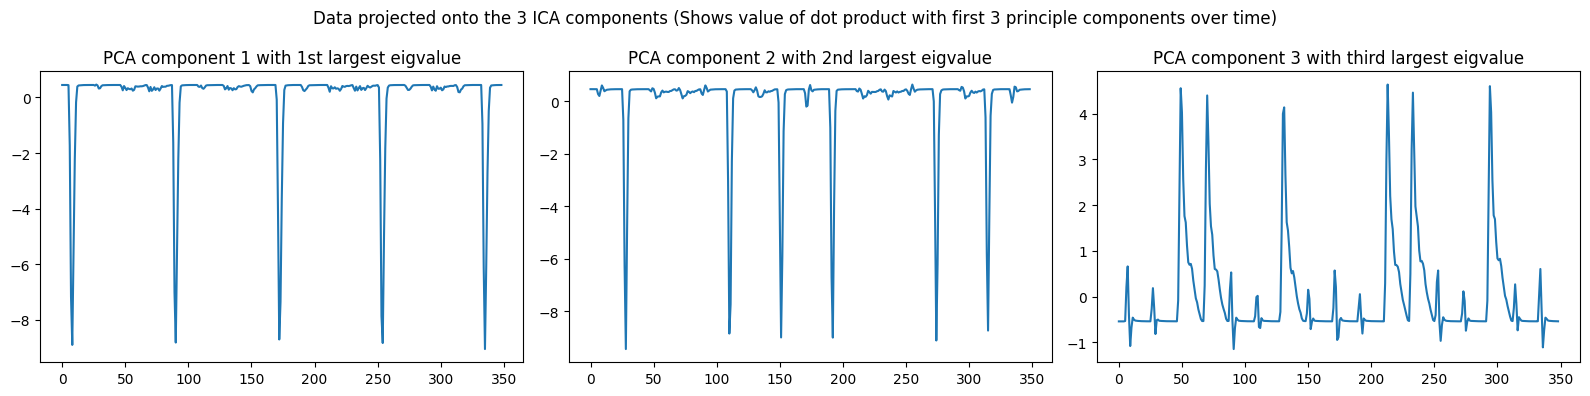

In [11]:


temp = (icaProjectMat) @ (data)
#component i=3 has the the longer snare 
v1 = temp[0]
v2 =  temp[1] 
v3 = temp[2]
# v4 = temp[3]
f, a = plt.subplots(1, 3, figsize=(16, 4))

a[0].plot(v1)
a[0].set_title(f'PCA component 1 with 1st largest eigvalue')

a[1].plot(v2)
a[1].set_title(f'PCA component 2 with 2nd largest eigvalue')

a[2].plot(v3)
a[2].set_title(f'PCA component 3 with third largest eigvalue')

# a[3].plot(v4)
# a[3].set_title(f'PCA component 4 with fourth largest eigvalue')

plt.suptitle('Data projected onto the 3 ICA components (Shows value of dot product with first 3 principle components over time)')
plt.subplots_adjust(top=0.85, hspace=0.5)

plt.tight_layout()
plt.show()


Text(0.5, 1.0, 'reconstructed from 3 ICA')

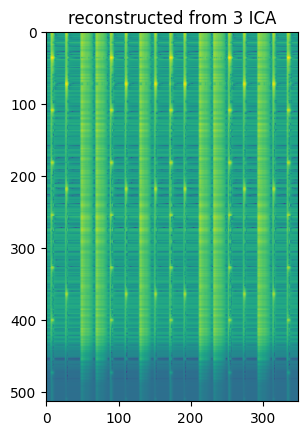

In [12]:
plt.imshow(10* np.log(np.abs(inverseIcaProjectMat@ (icaProjectMat @ data) + mean)))
plt.title('reconstructed from 3 ICA')

### Analysis

ICA clearly does a much better job at picking up the independent sounds in our audio. We see in the plot of the projection of the data onto the ICA components (versus the cooresponding plot for the PCA components) that the sounds correlate much less with the components of the other two sounds and more with the component of its sound (relatively). This advantage over PCA makes sense as we sought to minimize the mutual information between the 3 ICA components.

## NMF

In [13]:
def NMF(data, numComponents = 3, numIter = 100): #assumes rows and variables and columns are instances
    W = np.random.rand(data.shape[0],numComponents)
    H = np.random.rand(numComponents,data.shape[1])

    for iter in range(numIter):
        H = getH(W,H,data)
        W = getW(W,H,data)

    return (W,H)
def getH(W,H,data):
    sumWX =  W.T@data
    sumWH =  np.sum(W@H,axis=0).reshape(1,-1)
    numerator  = sumWX /(sumWH +1e-6)
    total = numerator / (np.sum(W,axis=0).reshape(-1,1) + 1e-6)
    return np.multiply(H,total)

def getW(W,H, data):
    sumWH =  np.sum(W@H,axis=1).reshape(-1,1)
    sumXH = data @ H.T
    numerator  = sumXH /(sumWH +1e-6)
    total = numerator / (np.sum(H,axis=1).reshape(1,-1) + 1e-6)
    return np.multiply(W,total)

In [14]:
W,H = NMF(spec,3)

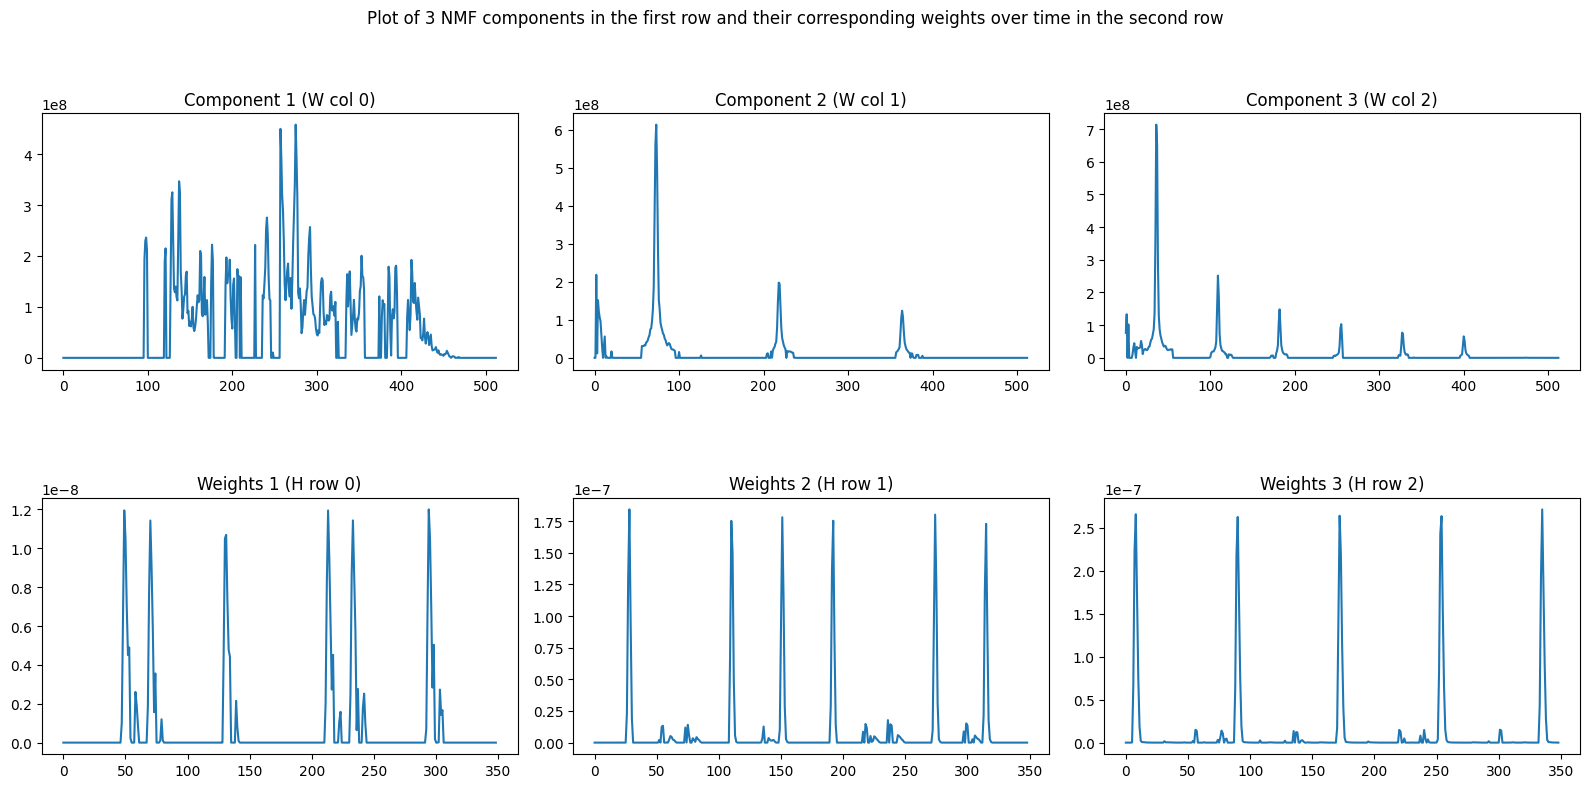

In [15]:
f, a = plt.subplots(2, 3, figsize=(16, 8))

v1 =  W[:,0]  
v2 =  W[:,1]
v3 = W[:,2]  

v4 =  H[0]
v5 = H[1]
v6 = H[2]

a[0, 0].plot(v1)
a[0, 0].set_title(f'Component 1 (W col 0)')

a[0, 1].plot(v2)
a[0, 1].set_title(f'Component 2 (W col 1)')

a[0, 2].plot(v3)
a[0, 2].set_title(f'Component 3 (W col 2)')

a[1, 0].plot(v4)
a[1, 0].set_title(f'Weights 1 (H row 0)')

a[1, 1].plot(v5)
a[1, 1].set_title(f'Weights 2 (H row 1)')

a[1, 2].plot(v6)
a[1, 2].set_title(f'Weights 3 (H row 2)')

plt.tight_layout()
plt.subplots_adjust(top=0.85, hspace=0.5)

plt.suptitle('Plot of 3 NMF components in the first row and their corresponding weights over time in the second row')
plt.show()


Text(0.5, 1.0, 'Reconstructed from NMF')

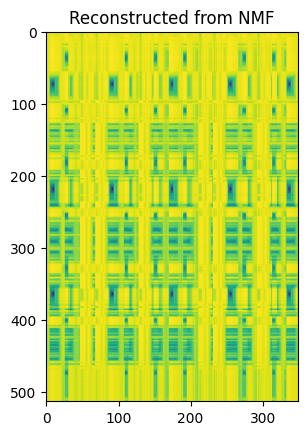

In [16]:
plt.imshow(np.log(W @ H))
plt.title('Reconstructed from NMF')

### Analysis
NMF does amazing!!!! We can see that each of the 3 sounds are represented by the 3 columns of W. We also see that where these columns appear over time in our spectrogram in exactly where our sounds occur in the spectrogram. There is pretty much no information about the other 2 sounds within the one of our W vectors. An interesting thing to consider here is that by having a non-negative constraint on its components and weights, NMF allows less wiggle room to get components that have some complex way of cancelling eachother when weighted and added together. Thish pushes NMF to find components that can work together to build the spectrograms different parts  

One thing to consider is that NMF seems to reconstruct a very unrealalistic looking spectrogram compared to ICA/PCA. This is likely partially due to PCA being the first part of both these methods and PCA seeks to maximize captured variance so it picks up more of the general spectrogram characteristics outside of the 3 sounds. NMF just looks to ideally reconstruct the data and it is constrained to 3 components, therefore it mainly focuses on finding the things that contain the majority of the information in our data.  

This prompts Overall this is our best method in terms of seperating/identifying the 3 sounds in the audio.


# Problem 2

In [17]:
data = np.load('digits-labels.npz')
digits = data['d']  
labels = data['l']  

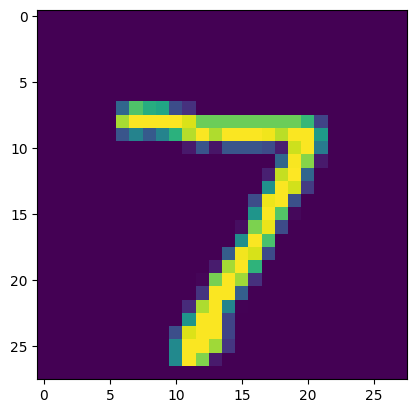

In [18]:
plt.imshow(np.reshape( digits[:,0],(28,28),'F'))
mean = np.mean(digits, axis =1).reshape(-1,1)
normDigits = digits - mean

### PCA

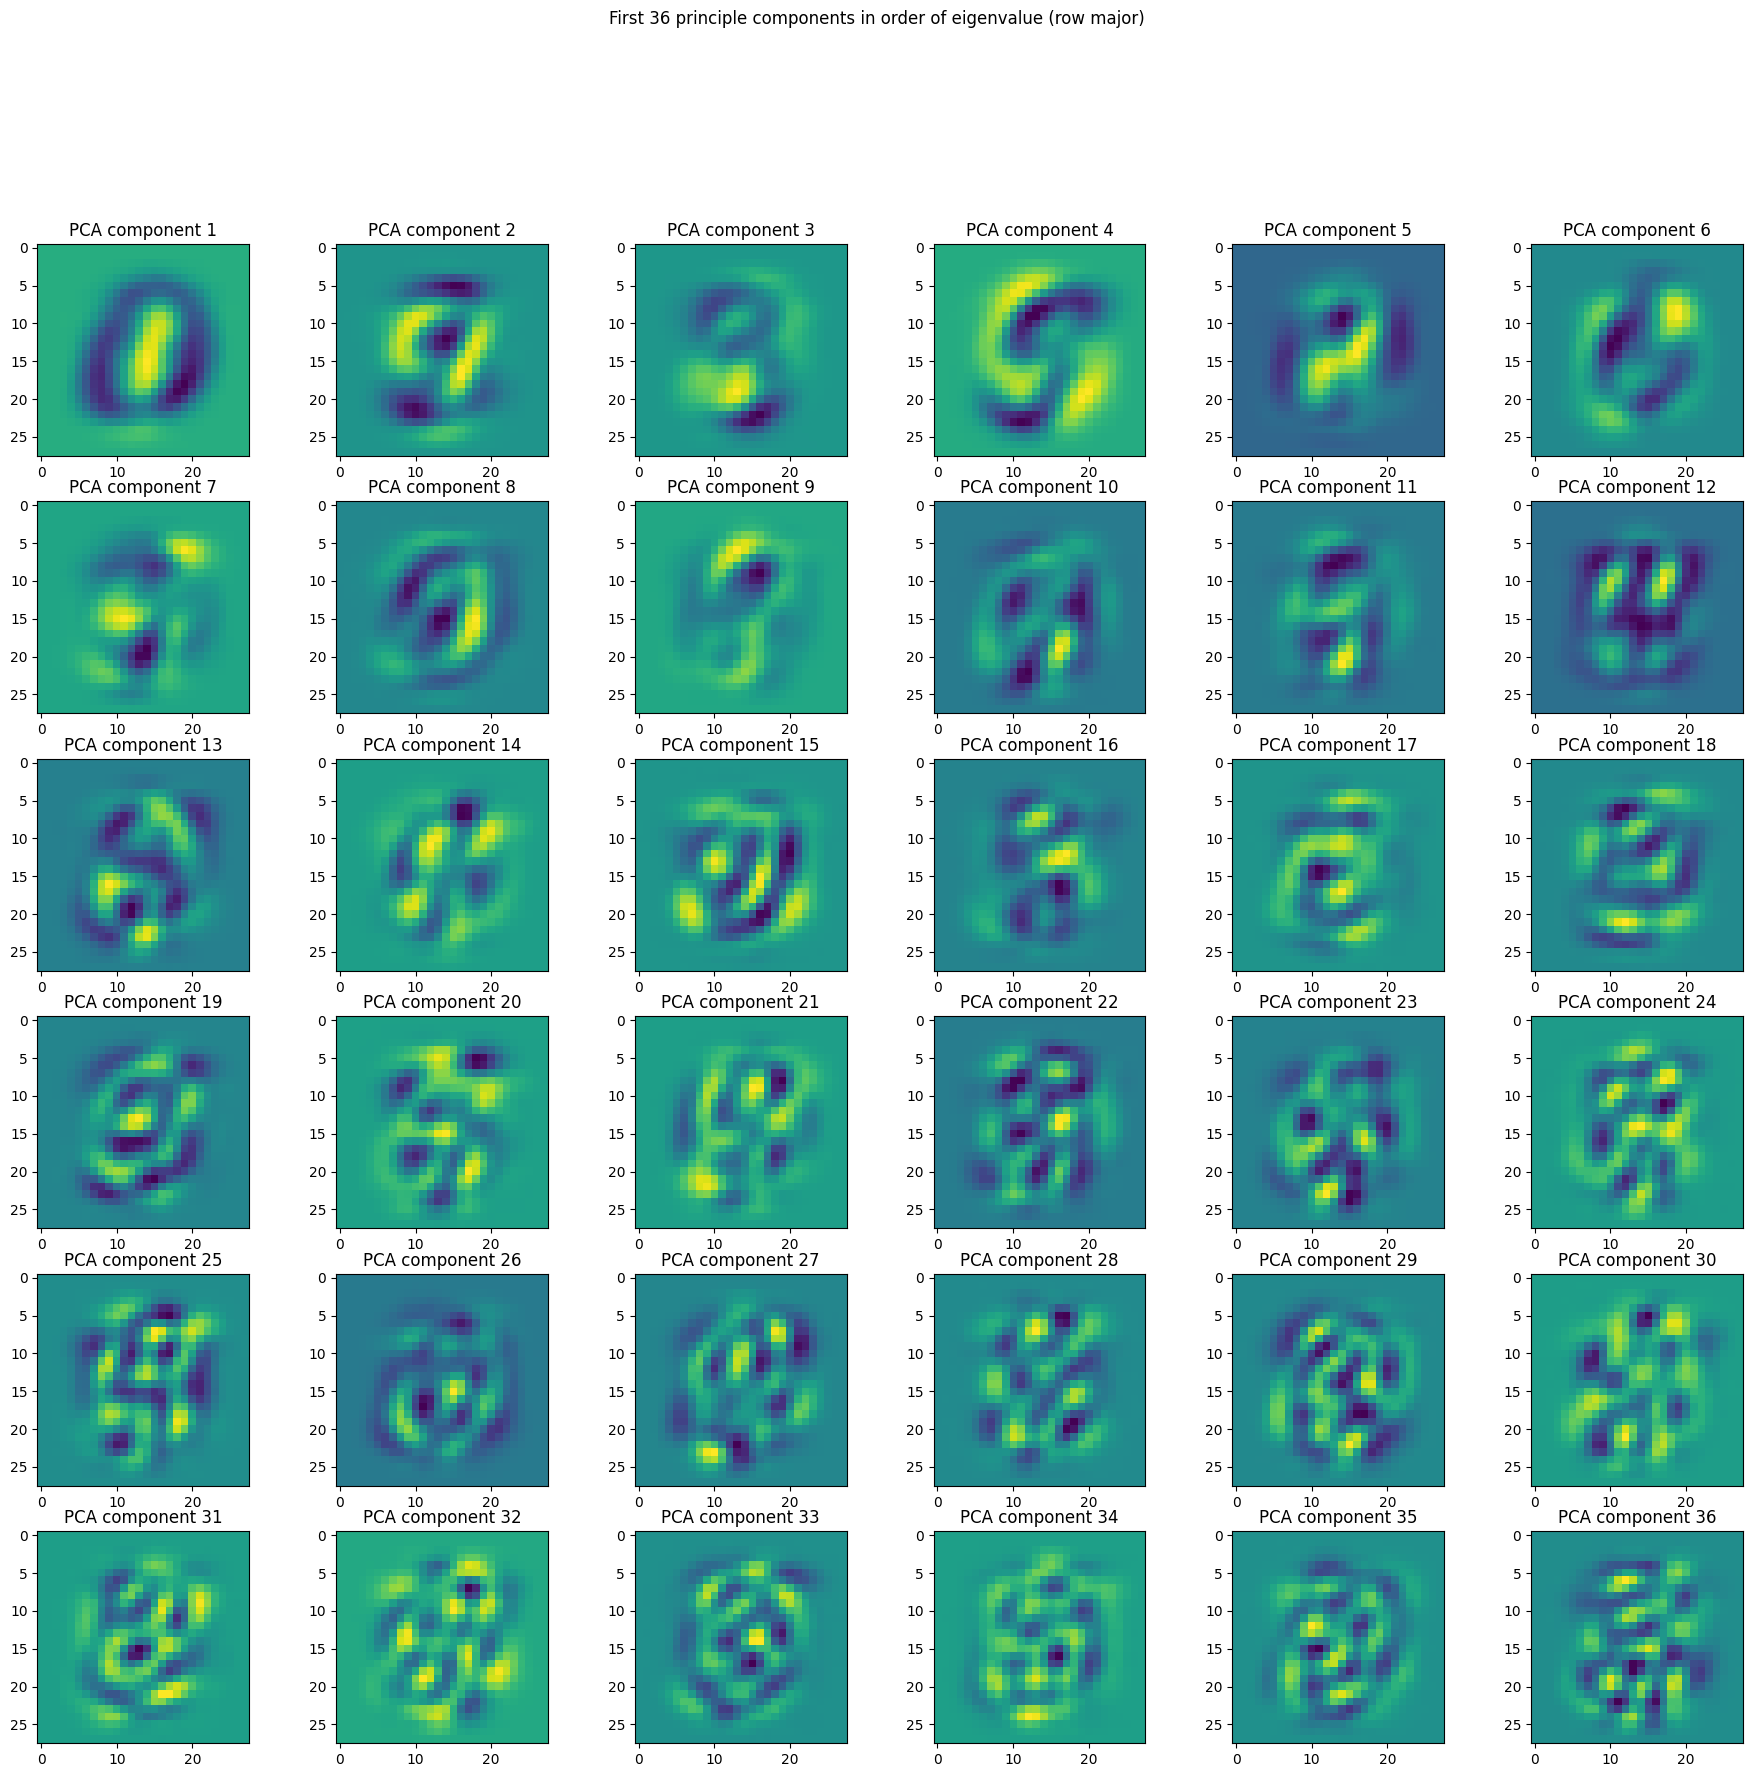

In [19]:
import numpy as np
import matplotlib.pyplot as plt
eigvecs, eigvals =  pca(normDigits)

stdev = np.std(digits.reshape(-1))
toShow = ((eigvecs)).T

num_components = 36
f, a = plt.subplots(num_components//6, 6, figsize=(18, 18))
for i in range(num_components):
    v = np.reshape(toShow[i], (28, 28), 'F')
    a[i//6][i % 6].imshow(v)
    a[i//6][i % 6].set_title(f'PCA component {i + 1}')

# a[1][0].plot(eigvals[:50])
# a[1][0].set_title(f'Eigen values of first 50 eigenvalues')

plt.tight_layout(pad=.5)
plt.subplots_adjust(top=0.85)

plt.suptitle('First 36 principle components in order of eigenvalue (row major)')
plt.show()

### ICA

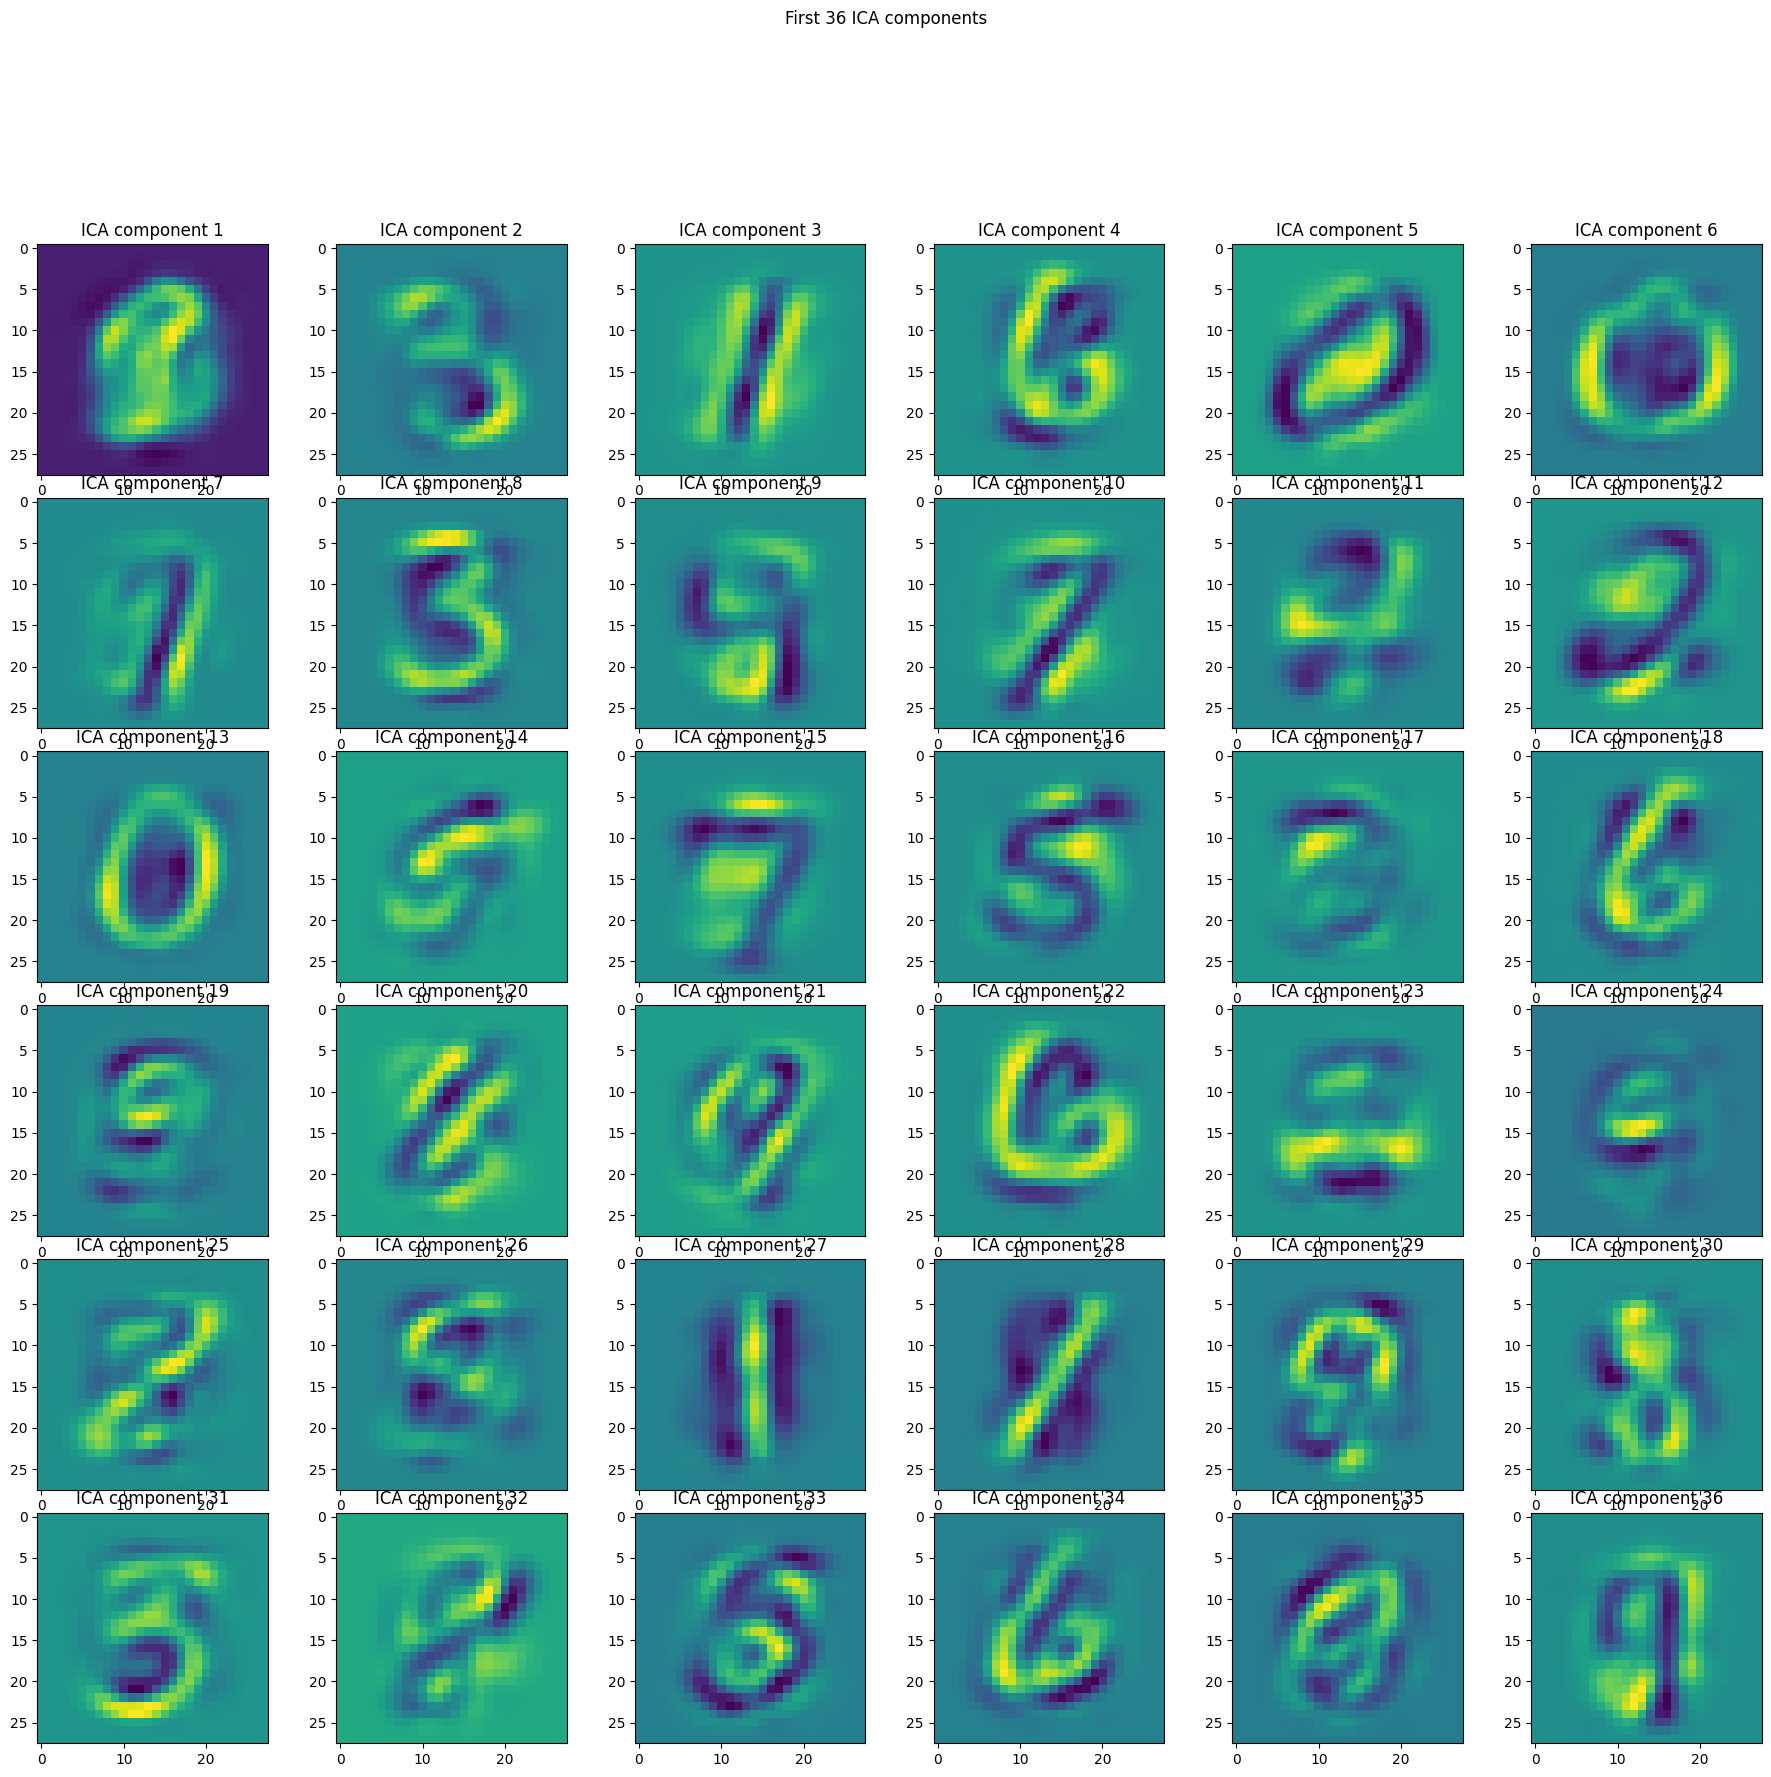

In [20]:
import numpy as np
import matplotlib.pyplot as plt
W =  ica(normDigits,PCAcomponents= num_components, maxIter=1000, alpha = 1e-5) 
toShow = ((np.linalg.pinv(W) )).T

num_components = 36
f, a = plt.subplots(num_components//6, 6, figsize=(18, 18))
for i in range(num_components):
    v = np.reshape(toShow[i], (28, 28), 'F')
    a[i//6][i % 6].imshow(v)
    a[i//6][i % 6].set_title(f'ICA component {i + 1}')

# # Plot the first 50 eigenvalues
# a[1][0].plot(eigvals[:50])
# a[1][0].set_title(f'Eigen values of first 50 eigenvalues')

plt.tight_layout(pad = .5)
plt.subplots_adjust(top=0.85, hspace=0.1)

plt.suptitle('First 36 ICA components')
plt.show()

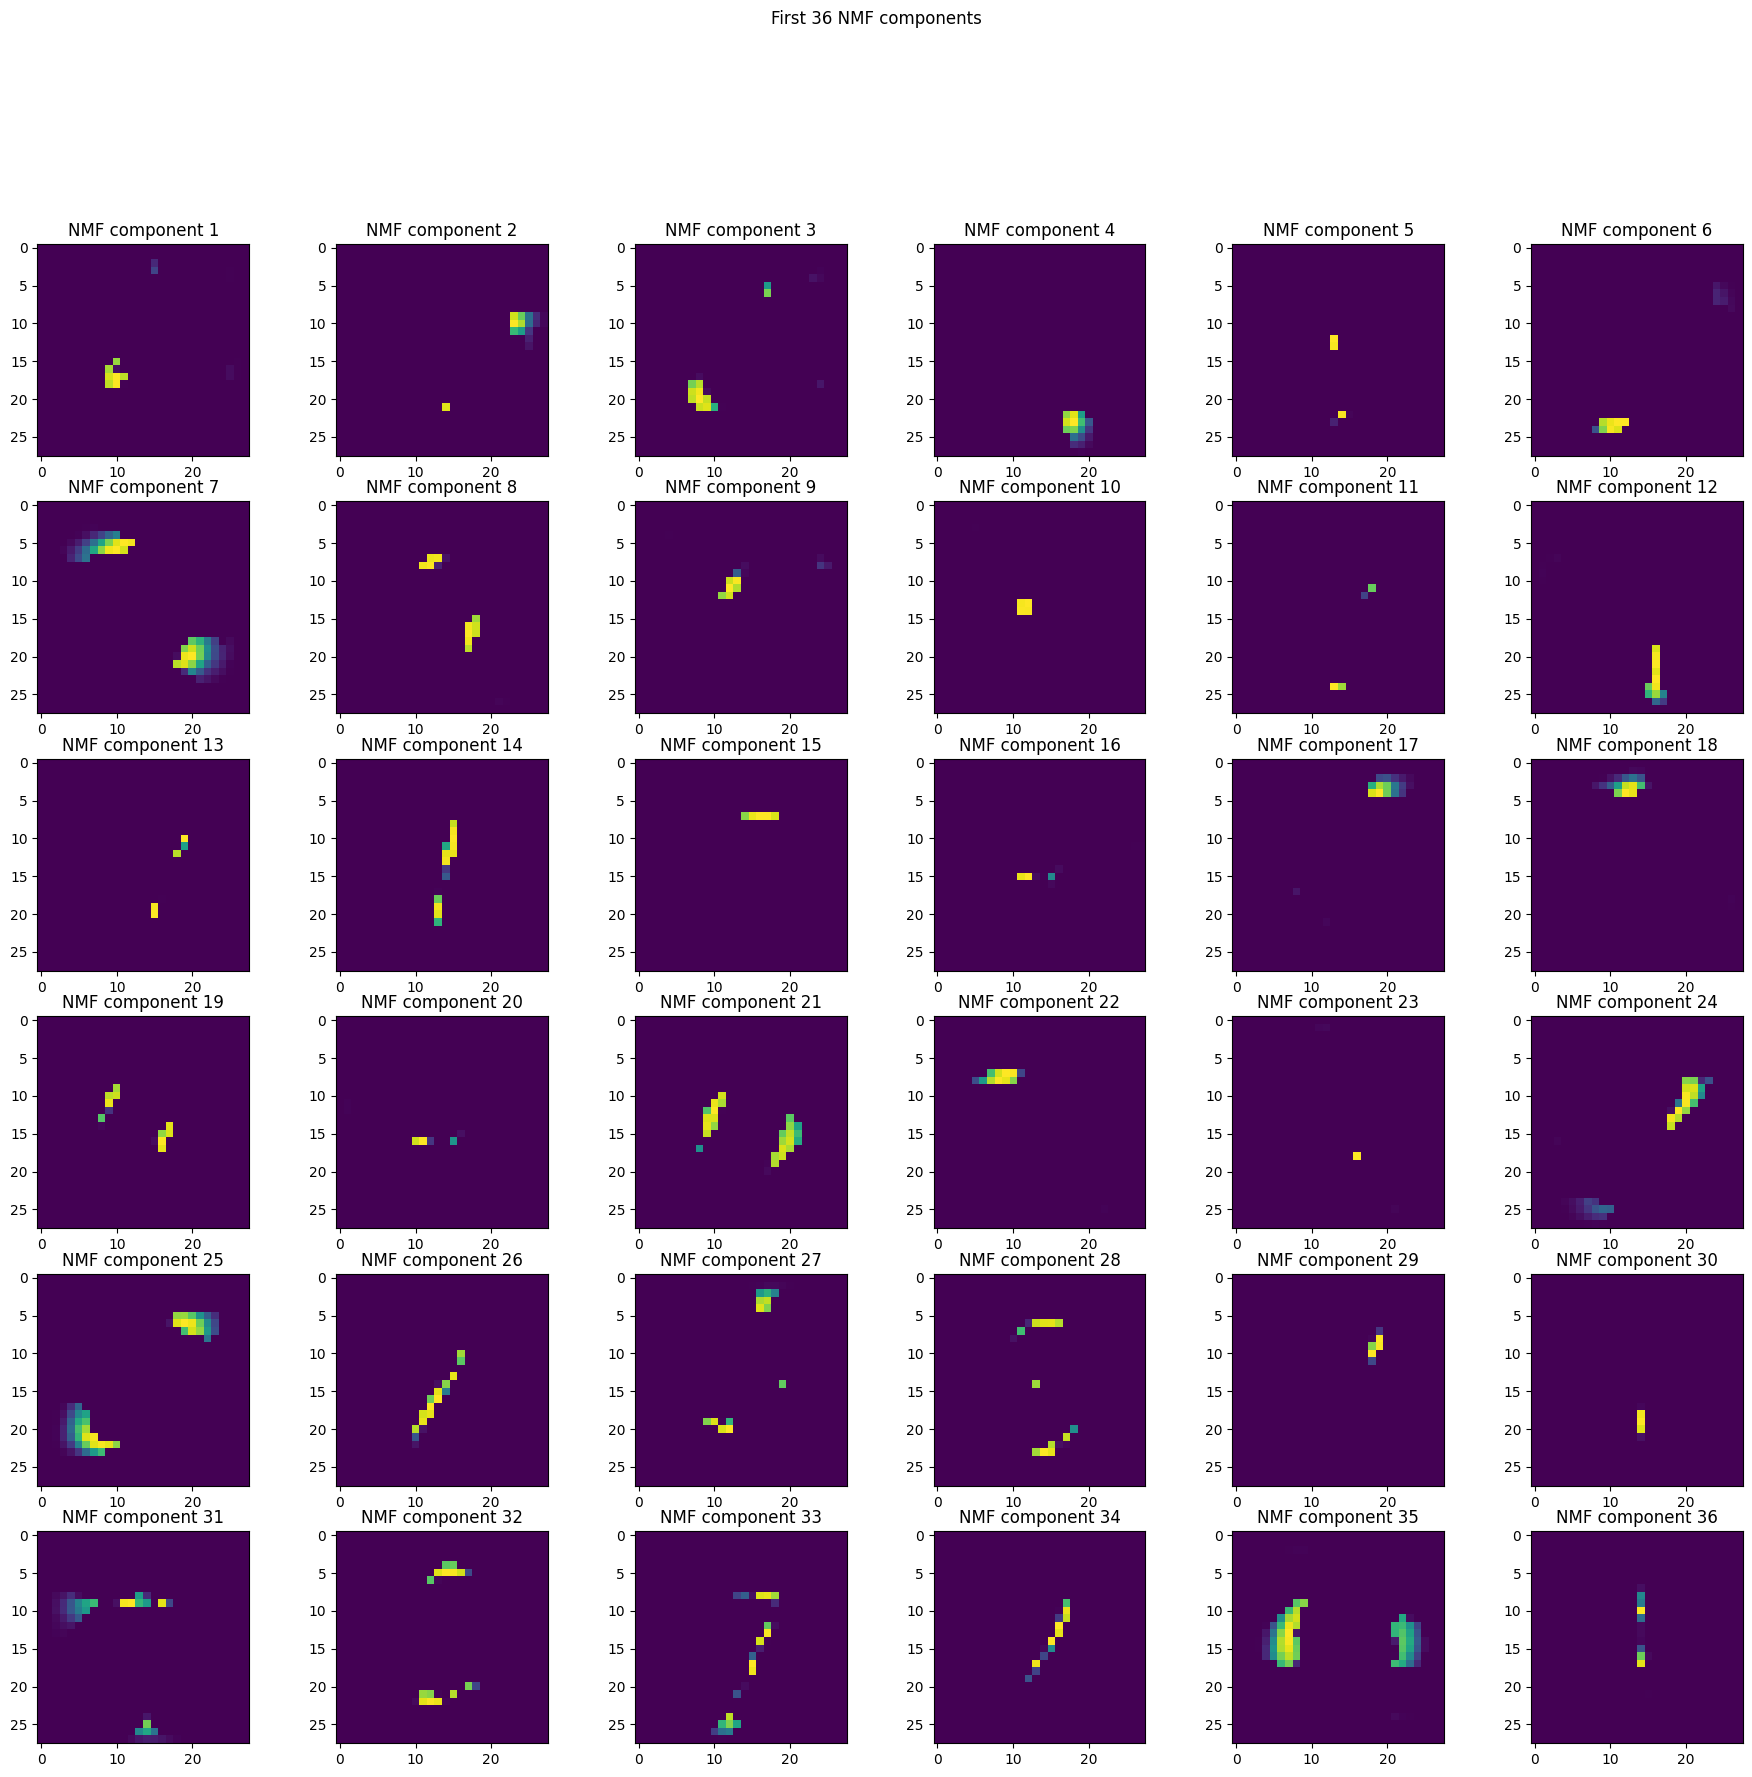

In [21]:
import numpy as np
import matplotlib.pyplot as plt
W,H =  NMF(digits,num_components)
toShow = W.T

num_components = 36
f, a = plt.subplots(num_components//6, 6, figsize=(18, 18))
for i in range(num_components):
    v = np.reshape(toShow[i], (28, 28), 'F')
    a[i//6][i % 6].imshow(v)
    a[i//6][i % 6].set_title(f'NMF component {i + 1}')

# # Plot the first 50 eigenvalues
# a[1][0].plot(eigvals[:50])
# a[1][0].set_title(f'Eigen values of first 50 eigenvalues')

plt.tight_layout(pad=.5)
plt.subplots_adjust(top=0.85)
plt.suptitle('First 36 NMF components')

plt.show()

### Analysis  
For PCA we do not get many clear connections between our components and a specific digit (outside of the first component which looks like a 0). This makes sense as PCA is mainly looking to capture the general variance of the data, and many digits are extremely similar so it would make sense to have some components capture information that is similar among many digits (i.e. Components 5 would generally have high correlation with 5,9, and maybe 6). Many of these components are looking for large amounts of energy in certain areas and edges in other areas. This edge detection be seen by the high intensity regions surrounded by low intensity regions.

For ICA, we see similar concepts of edge detection and energy detection but amazingly we also see that our components are much mroe often specifically associated with a digit. This makes sense, as by taking PCA and adding the constraint that we must minimize mutual information and maximize individual information, we push our components to capture individual things in our dataset rather than common sources of variance between all the things in our dataset. We even see that multiple componnets are made for the different common drawings of digits (i.e. Look at component 7 vs component 10). Some more challenging number like 2 and 4 are less clearly captured.  

For NMF, we do not get entire digits but rather we get the "building blocks" that can build up any digit. This is likely because, by having a non-negative constraint on its components and weights, NMF allows less wiggle room to get components that have some complex way of cancelling eachother when weighted and added together. Thish pushes NMF to find components that can work together to build the spectrograms different parts. Additionally, not starting from PCA means there is no reason why NMF would look to capture high variance in the image. This allows each NMF component to focus on a individual building block for each component rather than the larger combination of many. 

In [22]:
digit_indices = np.where(labels == 6)[0]
data6 = digits[:,digit_indices]


In [23]:
data6normalized  = data6 - np.mean(data6,axis = 1).reshape(-1,1)

In [24]:
eigvecs, eigvals = pca(data6normalized)
PCAproj = eigvecs.T[:2] @ data6normalized

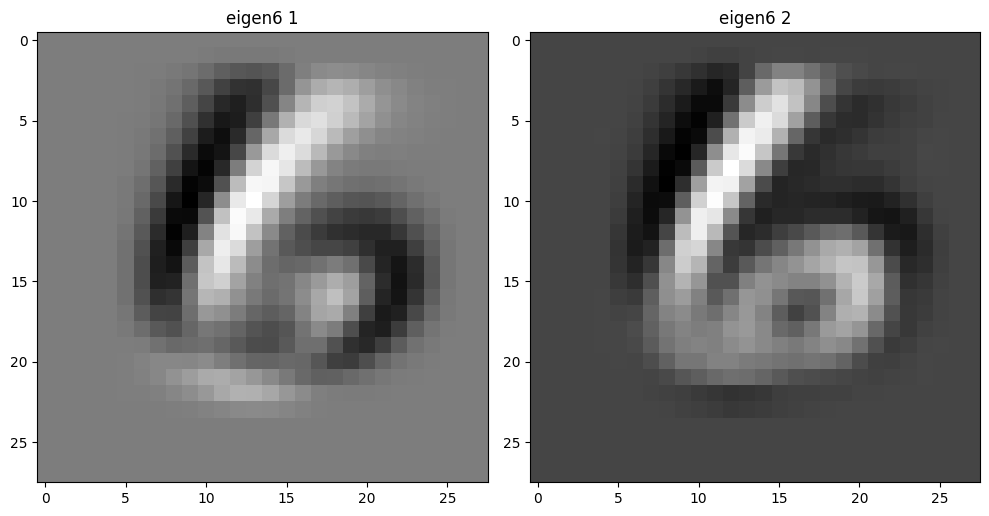

In [25]:

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
image1 = np.reshape(eigvecs.T[0] , (28, 28), 'F')
plt.imshow(image1, cmap='gray')
plt.title('eigen6 1')

plt.subplot(1, 2, 2)
image2 = np.reshape(eigvecs.T[1], (28, 28), 'F')
plt.imshow(image2, cmap='gray')
plt.title('eigen6 2')

plt.tight_layout()
plt.show()

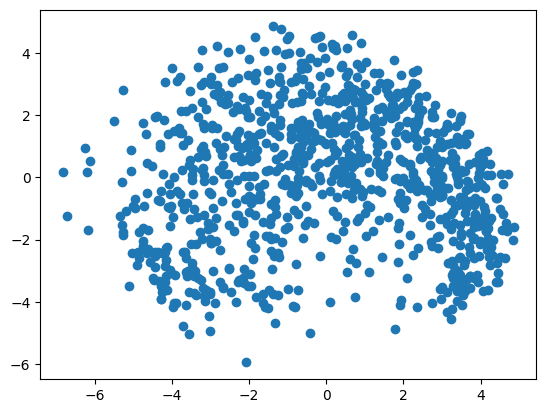

In [26]:
plt.scatter(PCAproj[0],PCAproj[1])

Text(0.5, 1.0, 'Scatter Plot with sixes')

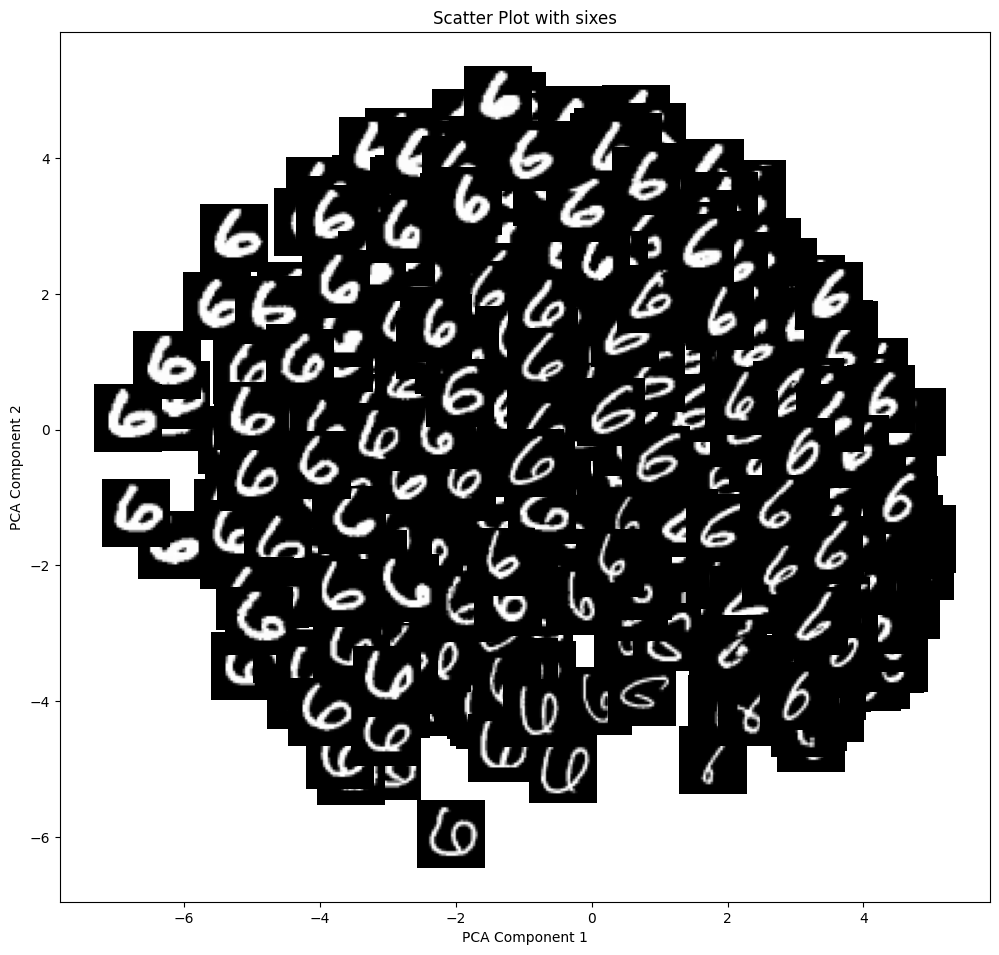

In [27]:
import numpy as np
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 12)) 
for i in range(len(PCAproj[0])):
    image = np.reshape(data6[:, i], (28, 28), 'F')
    plt.imshow(image, extent=(PCAproj[0][i]-0.5, PCAproj[0][i]+0.5, PCAproj[1][i]-0.5, PCAproj[1][i]+0.5), cmap='gray')
    plt.xlim([min(PCAproj[0]) - 1, max(PCAproj[0]) + 1])  
    plt.ylim([min(PCAproj[1]) - 1, max(PCAproj[1]) + 1]) 
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Scatter Plot with sixes')

#### ANALYSIS of PCA  

A 6 that has a top that curves more to the right has a higher value when projected to PCA component 1. A 6 that is more thick (total white) has a higher value for PCA component 2

In [28]:
def distanceMat(data, k =6):  #Floyd Marshall after putting some values in based on NN (intuitively assumes nearby distance is geodesic distance and then fills in rest from there)
    toReturn = np.ones((data.shape[1], data.shape[1])) *np.inf # row contains distance to each of columns
    for i in range(data.shape[1]):
        dist = np.linalg.norm(data - data[:,i].reshape(-1,1), axis=0)
        indices = np.argpartition(dist, k + 1)
        for j in indices:
            if(j == i):
                toReturn[i,j] = 0
            else:
                toReturn[i,j] = dist[j]
    #if you somehow have very outlierish data this may be useful? Not now though. Also can be done at end if still infs
    # for i in range(data.shape[1]):
    #     for j in range(data.shape[1]):
    #         toReturn[i,j] = min(toReturn[i][j], toReturn[j][i])
    return floyd_warshall(toReturn)

def floyd_warshall(data):
    num_nodes = data.shape[1]
    toReturn = np.copy(data)

    for i in range(num_nodes):
        mask = np.tile(toReturn[i], (num_nodes, 1))
        mask = np.minimum(mask, mask.T)
        toReturn = np.minimum(toReturn, toReturn.T + mask)
    
    return toReturn
                   
def ISOMAP(data,distMat = None, k = 6): # if you pass DistMat it will skip computing it
    if distMat is None:
        distMat = distanceMat(data, k)
    
    N = distMat.shape[0]    #this code and below is implementation of MDS preserving eucilidian distance
    P = np.identity(N) - 1/N *np.ones((N,N))
    temp = -1/2*(P @ distMat @ P)
    U,S,V = np.linalg.svd(temp)
    return np.sqrt(np.diag(S)) @ V

In [29]:
Dmat = np.load("distMat.npy")
dataISO = ISOMAP(data6)
print()

In [30]:
print(dataISO.shape)

(958, 958)


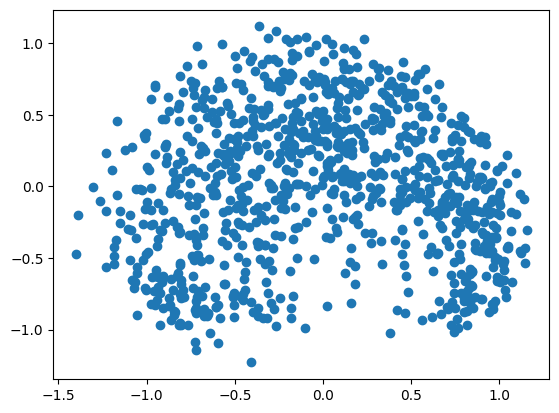

In [31]:
plt.scatter(dataISO[0],dataISO[1])



Text(0.5, 1.0, 'Scatter Plot with Sixes')

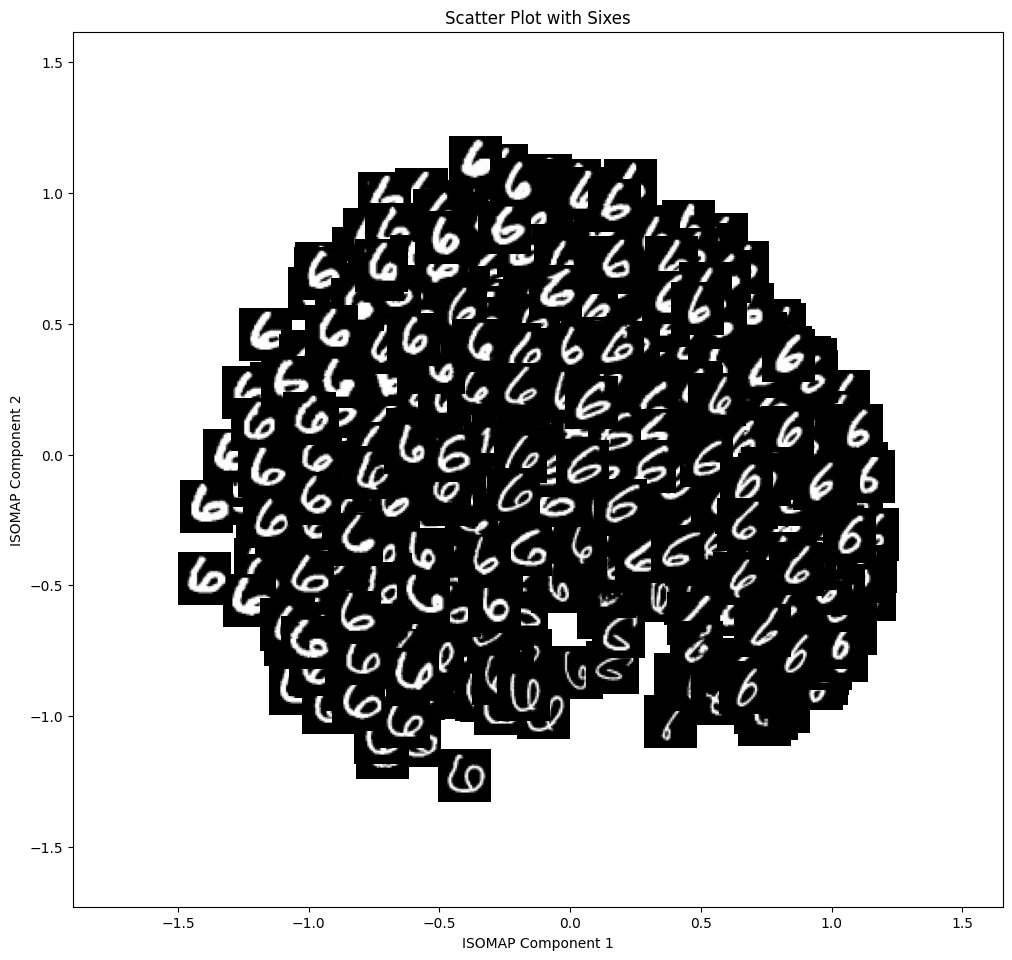

In [32]:
plt.figure(figsize=(12, 12)) 

for i in range(len(dataISO[0])):
    image = np.reshape(data6[:, i], (28, 28), 'F')
    plt.imshow(image, extent=(dataISO[0][i]-.1, dataISO[0][i]+.1, dataISO[1][i]-.1, dataISO[1][i]+.1), cmap='gray')
    plt.xlim([min(dataISO[0]) - .5, max(dataISO[0]) + .5])  
    plt.ylim([min(dataISO[1]) - .5, max(dataISO[1]) + .5]) 
plt.xlabel('ISOMAP Component 1')
plt.ylabel('ISOMAP Component 2')
plt.title('Scatter Plot with Sixes')

### ISOMAP ANALYSIS

With two isomap components we see that there is a Arch in the plot of our data. If we follow this arch from the bottom left up then around to the right to the bottom right, we see that the top tail of the six moves circularly with the data, Similarly, if we travel away from the point of curvature of the arch we see that the thickness of the sixes generally increases. ISOMAP seems to have found that the endpoint of the top tail of the sixes people draw tends to follow a curved pattern and the thickness follows some pattern related to the distance from the center of the arch.


We see similar patterns found for PCA and ISOMAP, but ISOMAPs points are more dense.